<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Проект 5. "Прогнозирование стоимости автомобиля"
# Выполнен Шашановым М. (SF-DST-12)
## Задача проекта: прогнозирование стоимости автомобиля по различным характеристикам

Импортируем необходимые библиотеки и kernel module с функциями предобработки, визуализации и пр.

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pprint import pprint
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# модуль с различными функциями по обработке и визуализации данных
import car_price_kernel_module as cm

In [2]:
pd.set_option('display.max_columns', 250) # показывать больше колонок
pd.set_option('display.max_rows', 250) # показывать больше строк

In [3]:
print('Python  :', sys.version.split('\n')[0])
print('Numpy   :', np.__version__)
print('Sklearn :', skl.__version__)

Python  : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy   : 1.18.5
Sklearn : 0.23.2


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
empty_array = np.array([])

# Setup

In [7]:
DIR_TRAIN     = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # предыдущий датасет
DIR_TRAIN_NEW = '../input/all-msk-auto-nov-2020/' # вновь собранный датасет
DIR_TEST      = '../input/sf-dst-car-price-prediction/'

VERSION     = 15
RANDOM_SEED = 42 # фиксируем RANDOM_SEED для повторяемости расчетов
VAL_SIZE    = 0.20 # 20% на тест
ITERATIONS  = 5000 # для CatBoost
LR          = 0.1 # для CatBoost

# Data

In [8]:
!ls '../input'

all-msk-auto-nov-2020		       sf-dst-car-price-prediction
parsing-all-moscow-auto-ru-09-09-2020


Для обучения моделей ML будет использоваться датасет "all-msk-auto-nov-2020", собранный на сайте auto.ru в ноябре 2020г. Предыдущий датасет для обучения не используется.

In [9]:
train = pd.read_csv(DIR_TRAIN_NEW + 'train.csv') # новый датасет для обучения модели
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

Получим информацию о датасетах

In [10]:
train.head(5)

,Unnamed: 0,index,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,location,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,0,0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,синий,{'id': '0'},Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,2.0 LTR,235 N12,Москва,"{'esp': True, 'airbag-driver': True, 'aux': Tr...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209286...,85452,2014.0,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0d AT (235 л.с.) 4WD,5.0,1604647120000,RUR,2016,1101191623-464cf4be,"{'id': '20228874', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2799000
1,1,1,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s80/11013...,чёрный,{'id': '0'},При покупке автомобиля до 15 ноября \n► Выгод...,2.5 LTR,249 N12,Москва,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216441...,116410,2009.0,"{'code': 'S80', 'name': 'S80', 'ru_name': 'S80...",S80,2.5 AT (249 л.с.),4.0,1604659835000,RUR,2013,1101345022-3e0e4f8c,"{'id': '7974165', 'name': 'II Рестайлинг', 'ru...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1277000
2,2,2,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc90/11009...,серый,"{'id': '22148941', 'name': 'Momentum', 'availa...",Официальный дилер Volvo в Москве и Московской ...,2.0 LTR,249 N12,Москва,"{'multi-wheel': True, 'heated-wash-system': Tr...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216468...,0,2019.0,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0 AT (249 л.с.) 4WD,5.0,1604474020000,RUR,2020,1100911068-4dd8f660,"{'id': '21552979', 'name': 'II Рестайлинг', 'r...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4861200
3,3,3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1100...,чёрный,{'id': '0'},Автодилер года 2020\n\nПобедитель в номинации ...,2.4 LTR,190 N12,Москва,"{'cruise-control': True, 'engine-proof': True,...",дизель,//avatars.mds.yandex.net/get-autoru-vos/209157...,83657,2013.0,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (190 л.с.) 4WD,5.0,1604656488000,RUR,2016,1100336634-a6643416,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1869000
4,4,4,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/11014...,чёрный,{'id': '0'},Объявление №690\n\nАвтомобиль в отличном состо...,2.4 LTR,170 N12,Москва,"{'engine-proof': True, 'cruise-control': True,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/210185...,118000,2004.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,2.4 AT (170 л.с.),4.0,1604638764000,RUR,2006,1101497967-8c590a51,"{'id': '2309989', 'name': 'I Рестайлинг', 'ru_...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,369000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36210 entries, 0 to 36209
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            36210 non-null  int64  
 1   index                 36210 non-null  int64  
 2   bodyType              36210 non-null  object 
 3   brand                 36210 non-null  object 
 4   car_url               36210 non-null  object 
 5   color                 36210 non-null  object 
 6   complectation_dict    36210 non-null  object 
 7   description           35210 non-null  object 
 8   engineDisplacement    36210 non-null  object 
 9   enginePower           36210 non-null  object 
 10  location              36210 non-null  object 
 11  equipment_dict        36210 non-null  object 
 12  fuelType              36210 non-null  object 
 13  image                 36210 non-null  object 
 14  mileage               36210 non-null  int64  
 15  modelDate          

In [12]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Большая часть колонок в train и test совпадают по смыслу и названию. Отберем и предобработаем наиболее существенные признаки для обучения моделей.

## Data Preprocessing

In [14]:
cm.print_duplicates_info(train)
cm.print_duplicates_info(test)

Num of duplicates by car_url: 0
Num of duplicates by sell_id: 0
Num of duplicates by car_url, sell_id: 0
Num of duplicates by car_url: 0
Num of duplicates by sell_id: 0
Num of duplicates by car_url, sell_id: 0


В train и test отсутствуют дубликаты по уникальным признакам car_url и sell_id, удаление не требуется

In [15]:
cat_cols = []
num_cols = []
add_cols = []

### bodyType

внедорожник 5 дв.    16049
седан                11474
лифтбек               2692
хэтчбек 5 дв.         1760
Name: bodyType, dtype: int64

Num of missing values: 0


седан                13147
внедорожник 5 дв.    12228
лифтбек               2232
хэтчбек 5 дв.         2124
Name: bodyType, dtype: int64

Num of missing values: 0


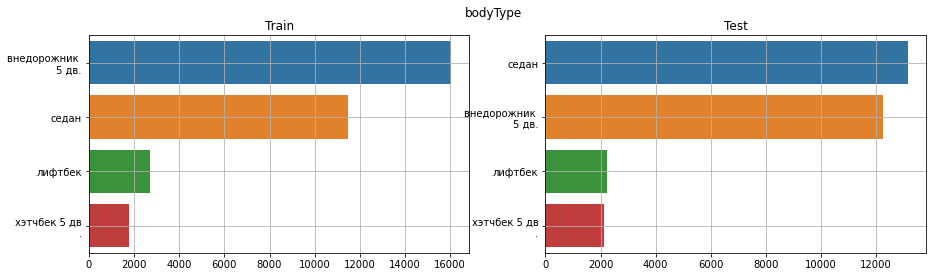

In [16]:
col = 'bodyType'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков. Очистим его значения, удалив кол-во дверей и объединив категории с различным числом по типу кузова, т.к. за кол-во дверей отвечает отдельный признак.

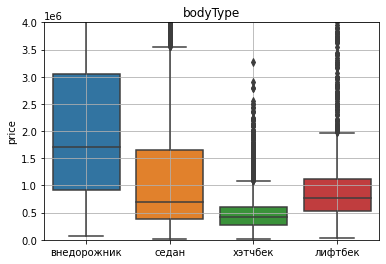

In [17]:
cat_cols.append(col)
train[col] = train[col].apply(cm.clear_body_type)
test[col] = test[col].apply(cm.clear_body_type)
cm.plot_cat_col_vs_price(train, col, [0, 4e6])

Заметно, что в train распределение цен зависит от данной категории, поэтому признак выглядит существенным.

### brand

VOLKSWAGEN    3769
MERCEDES      3738
BMW           3730
NISSAN        3621
Name: brand, dtype: int64

Num of missing values: 0


BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
Name: brand, dtype: int64

Num of missing values: 0


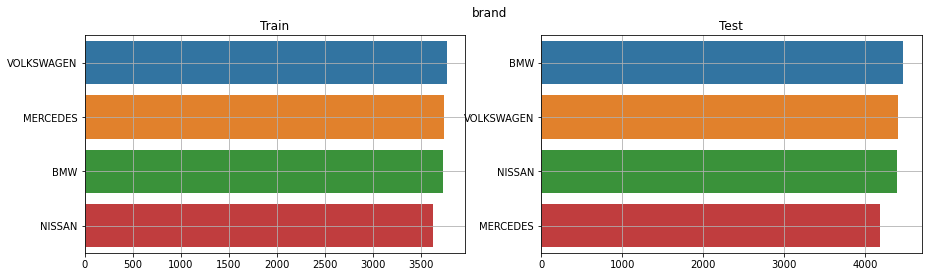

In [18]:
col = 'brand'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков, в доп обработке нет необходимости.

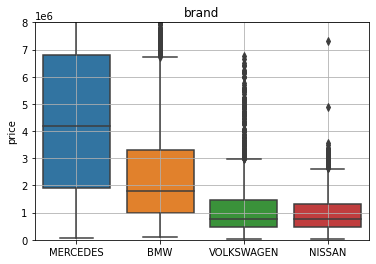

In [19]:
cat_cols.append(col)
cm.plot_cat_col_vs_price(train, col, [0, 8e6])

Признак существенный, распределение цен зависит от бренда. Наиболее существенный разброс цен для бренда MERCEDES, и средний уровень цен выше, чем для остальных брендов

### Привод

полный      18274
передний    15172
задний       2764
Name: Привод, dtype: int64

Num of missing values: 0


передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

Num of missing values: 0


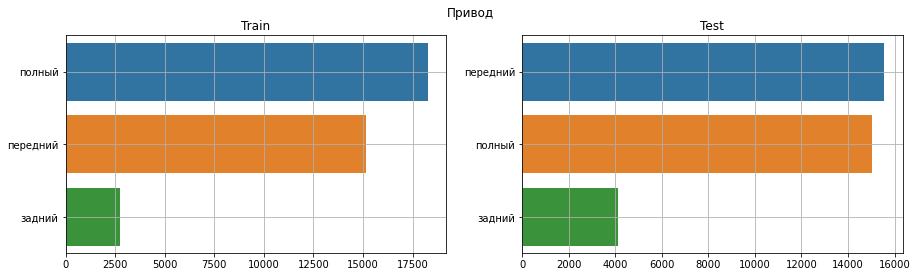

In [20]:
col = 'Привод'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков, в доп обработке нет необходимости.

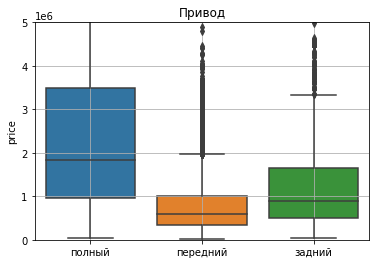

In [21]:
cat_cols.append(col)
train[col] = train[col].apply(cm.clear_car_drives)
test[col] = test[col].apply(cm.clear_car_drives)
cm.plot_cat_col_vs_price(train, col, [0, 5e6])

Заметно, что цена зависит от категории привода

### fuelType

бензин     29429
дизель      6411
гибрид       306
электро       59
Name: fuelType, dtype: int64

Num of missing values: 0


бензин     28601
дизель      5800
гибрид       223
электро       55
Name: fuelType, dtype: int64

Num of missing values: 0


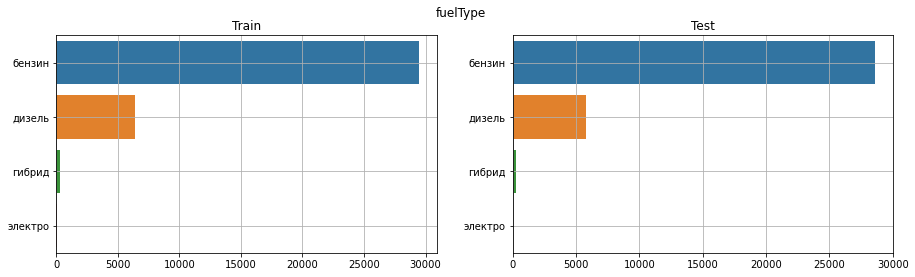

In [22]:
col = 'fuelType'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков, в доп обработке нет необходимости. Категории гибрид и электро встречаются гораздо реже по сравнению с категориями бензин, дизель.

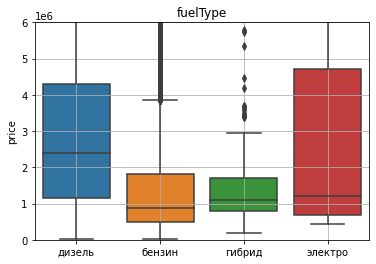

In [23]:
cat_cols.append(col)
cm.plot_cat_col_vs_price(train, col, [0, 6e6])

Распределение цен в train зависит от категории. Интересно, что для электро наблюдается наибольший разброс цен, при том, что эта категория встречается наиболее редко.

### color

чёрный    12813
серый      8190
белый      7050
синий      3643
Name: color, dtype: int64

Num of missing values: 0


чёрный         11010
белый           6133
серебристый     4113
серый           3984
Name: color, dtype: int64

Num of missing values: 0


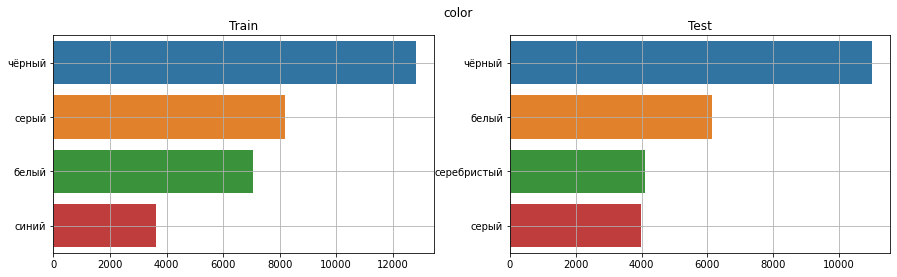

In [24]:
col = 'color'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков. Оставим только те категории, которые одновременно встречаются и в train, и в test, заменив остальные на other. В дальнейшем это дает небольшое улучшение для финальной модели

Before:  {'len1': 0, 'len2': 4}
After:  {'len1': 0, 'len2': 1}


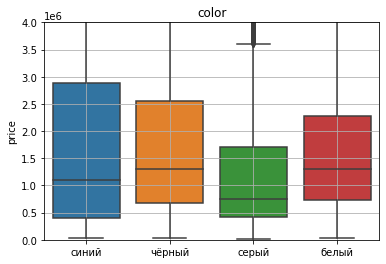

In [25]:
cat_cols.append(col)
train[col], test[col] = cm.delete_not_matching_categories(train[col], test[col])
cm.plot_cat_col_vs_price(train, col, [0, 4e6])

Цена все же слабее, но зависит от цвета автомобиля. Черный или белый в среднем чуть выше, чем синий или серый.

### model_name

OCTAVIA      1417
OUTLANDER    1060
X-TRAIL       818
POLO          733
Name: model_name, dtype: int64

Num of missing values: 0


OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
Name: model_name, dtype: int64

Num of missing values: 0


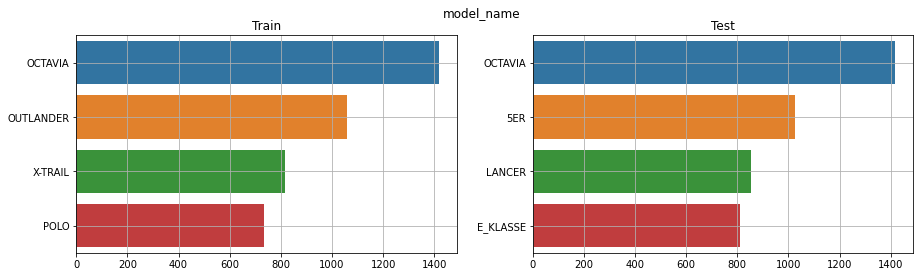

In [26]:
col = 'model_name'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Это категориальный признак без пропусков, но который необходимо обработать, прежде чем использоваться в модели. В train и test одно и тоже название модели может быть записано по-разному, устраним эти разночтения. А так же в конце объединим все категории, которые не встречаются одновременно в обоих датасетах, в категорию other (55 и 62 категории соответственно).

Before:  {'len1': 55, 'len2': 62}
After:  {'len1': 0, 'len2': 0}


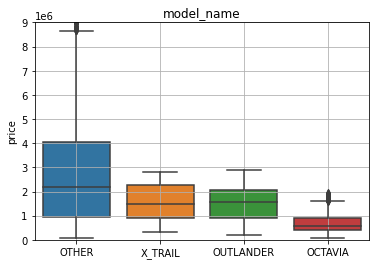

In [27]:
cat_cols.append(col)
train[col] = cm.clear_model_name(train[col])
test[col] = cm.clear_model_name(test[col])
train[col], test[col] = cm.delete_not_matching_categories(train[col], test[col])
cm.plot_cat_col_vs_price(train, col, [0, 9e6])

Признак существенный, поскольку распределение цен различается в зависимости от категории 

### vendor

EUROPEAN    20912
JAPANESE    15298
Name: vendor, dtype: int64

Num of missing values: 0


EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

Num of missing values: 0


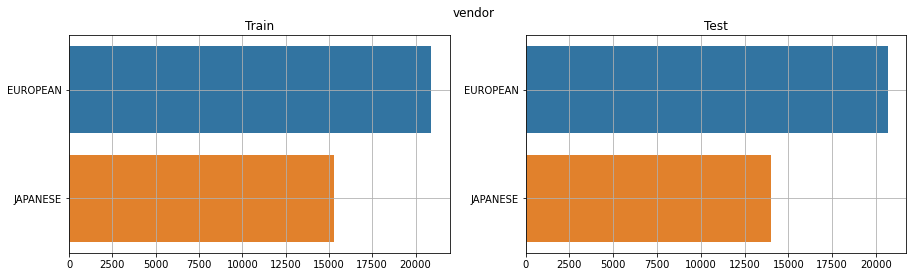

In [28]:
col = 'vendor'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Данный признак используем без предобработки, не содержит пропусков и является категориальным. 

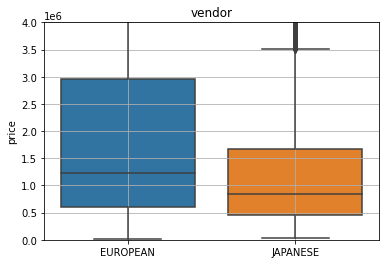

In [29]:
cat_cols.append(col)
cm.plot_cat_col_vs_price(train, col, [0, 4e6])

Автомобили из Европы в среднем стоят дороже и имеют больший разброс, чем японские автомобили.

### vehicleTransmission

автоматическая      19626
механическая         6885
роботизированная     4866
вариатор             4833
Name: vehicleTransmission, dtype: int64

Num of missing values: 0


автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Num of missing values: 0


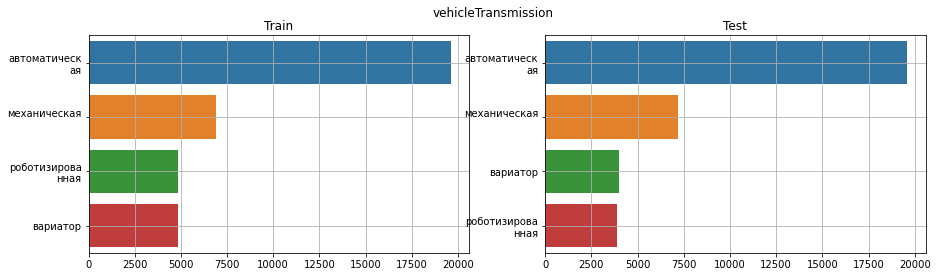

In [30]:
col = 'vehicleTransmission'
cm.print_col_info(train[col])
cm.print_col_info(test[col])
cm.plot_top_categories(train, test, col)

Категориальный признак без пропусков, существенно преобладают автомобили с автоматической трансмиссией

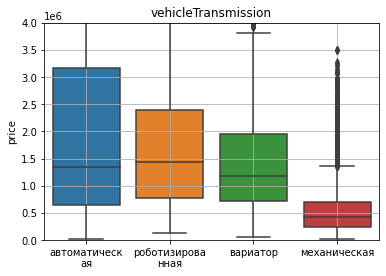

In [31]:
cat_cols.append(col)
cm.plot_cat_col_vs_price(train, col, [0, 4e6])

Распределение цен зависит от данного признака, автомобили с механикой стоят существенной дешевле, что логично

### productionDate

In [32]:
col = 'productionDate'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

2020    6584
2012    2343
2008    2226
2011    2166
Name: productionDate, dtype: int64

Num of missing values: 0


2012    2798
2008    2606
2011    2589
2013    2488
Name: productionDate, dtype: int64

Num of missing values: 0


Численный признак без пропусков, используем в модели. 

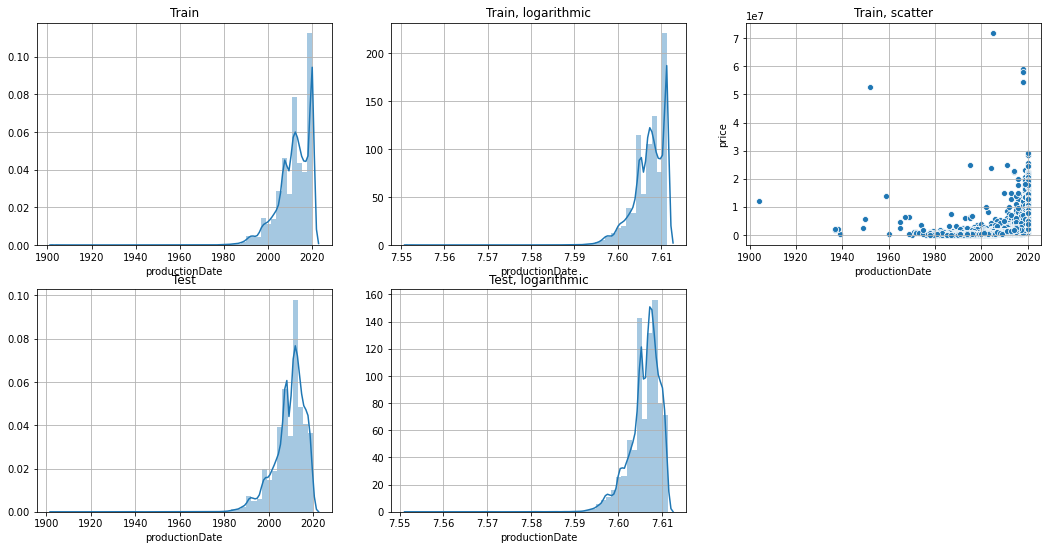

In [33]:
num_cols.append(col)
cm.plot_num_col_vs_price_unified(train, test, col)

Наблюдается длинный хвост распределения в области ранних дат (до 1980), возможно необходимо применить логарифмирование признака. На диаграмме рассеяния заметен тренд, что автомобили с более поздней датой производства стоят дороже

### engineDisplacement

In [34]:
col = 'engineDisplacement'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

2.0 LTR    9648
1.6 LTR    4750
3.0 LTR    3615
1.8 LTR    2592
Name: engineDisplacement, dtype: int64

Num of missing values: 0


2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
Name: engineDisplacement, dtype: int64

Num of missing values: 0


Численный признак без пропусков, необходима предобработка. Возьмем сами численные значения без единиц измерения, заполняя пропуски для электрокаров нулевыми значениями.

In [35]:
num_cols.append(col)
test.loc[test[col] == " LTR", col] = "0.0 LTR"
display(train.query('fuelType == "электро"').engineDisplacement.value_counts())
display(test.query('fuelType == "электро"').engineDisplacement.value_counts())
train[col] = train[col].apply(cm.clear_engine_disp).astype(np.float32)
test[col] = test[col].apply(cm.clear_engine_disp).astype(np.float32)

0.0 LTR    59
Name: engineDisplacement, dtype: int64

0.0 LTR    55
Name: engineDisplacement, dtype: int64

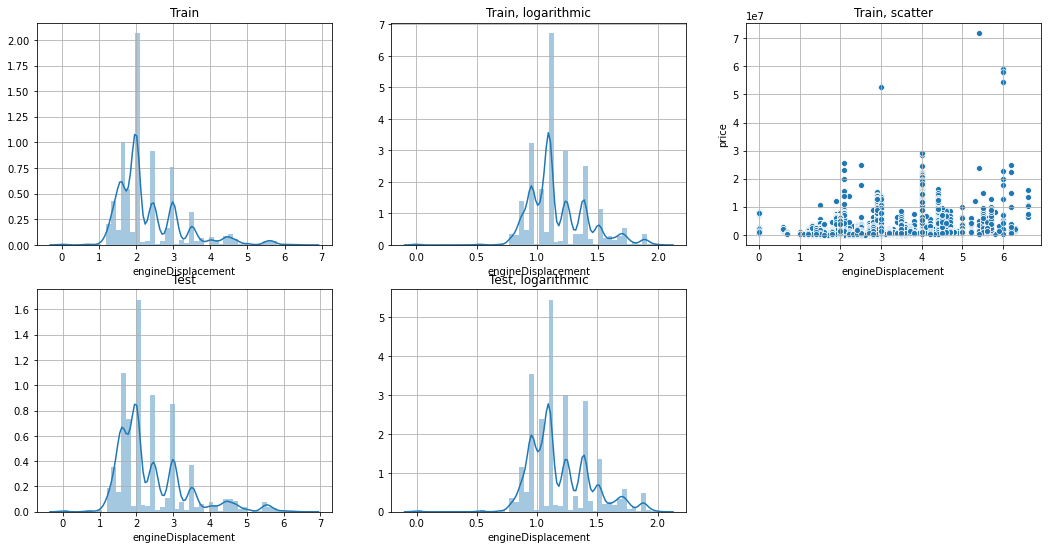

In [36]:
cm.plot_num_col_vs_price_unified(train, test, col)

Распределение близко к нормальному, особенно после логарифмирования. На диаграмме рассеяния нет ясного тренда зависимости цены от данного признака

### mileage

In [37]:
col = 'mileage'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

0         6616
200000     364
250000     293
180000     291
Name: mileage, dtype: int64

Num of missing values: 0


200000    436
150000    382
300000    381
180000    347
Name: mileage, dtype: int64

Num of missing values: 0


Численный признак без пропусков, нет необходимости в предобработке. 

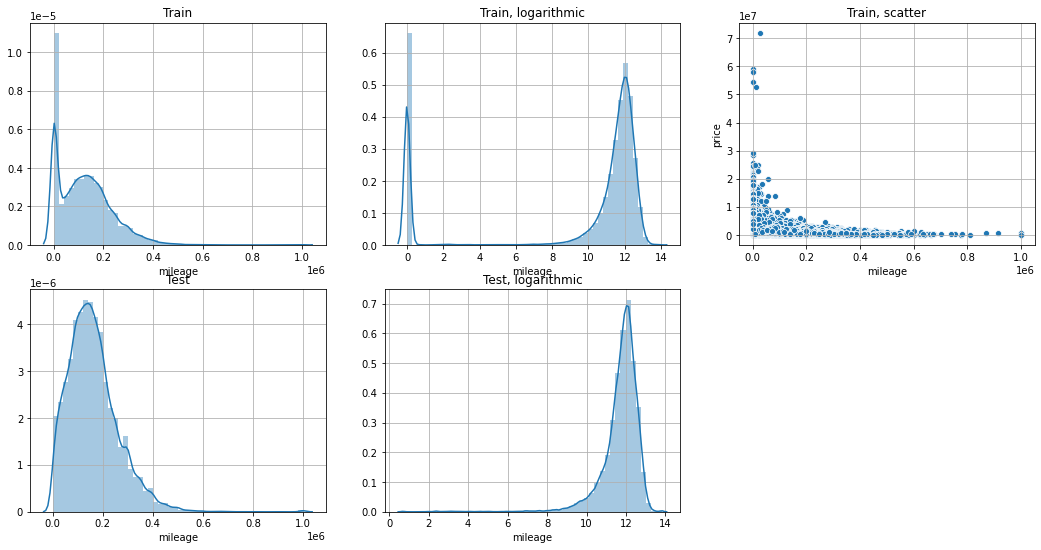

In [38]:
num_cols.append(col)
cm.plot_num_col_vs_price_unified(train, test, col)

Разброс значений уменьшается после логарифмирования. Заметно, что в train присутствуют как автомобили с пробегом, так и без (первый максимум вблизи нулевых значений). В test же присутствуют только автомобили с ненулевым пробегом. Распределение таких автомобилей близко к нормальному, диаграмма рассеяния говорит об обратной пропорциональности цены от признака.

### enginePower

In [39]:
col = 'enginePower'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

249 N12    2701
150 N12    2560
110 N12    1258
190 N12    1091
Name: enginePower, dtype: int64

Num of missing values: 0


249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
Name: enginePower, dtype: int64

Num of missing values: 0


Численный признак без пропусков, необходима предобработка. Удалим единицу измерения и приведем все значения в числовой формат.

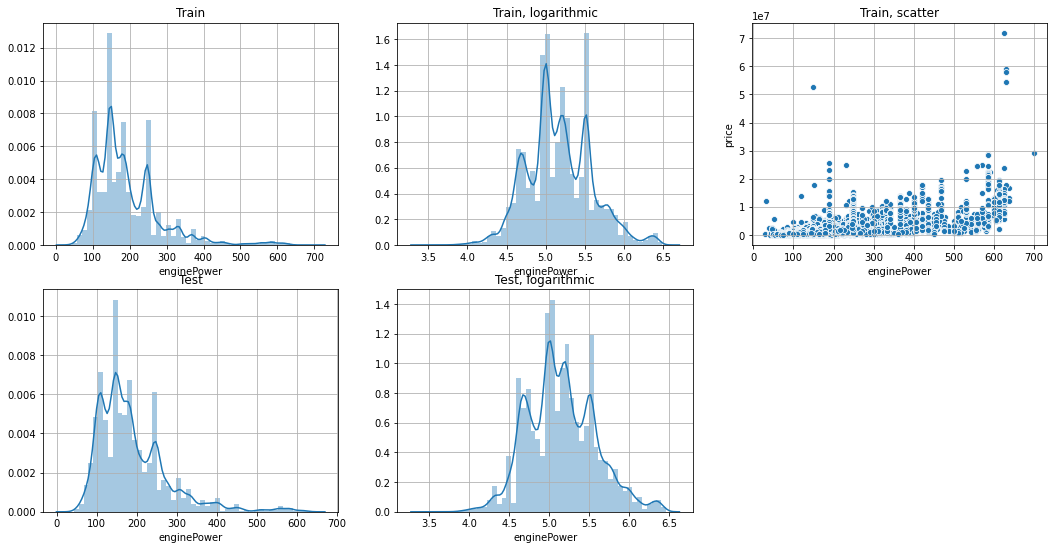

In [40]:
num_cols.append(col)
train[col] = train[col].apply(cm.clear_engine_power).astype(np.float32)
test[col] = test[col].apply(cm.clear_engine_power).astype(np.float32)
cm.plot_num_col_vs_price_unified(train, test, col)

Заметно, что после логарифмирования распределение признака становится близко к нормальному (как в train, так и в test). На диаграмме рассеяния можно наблюдать тренд на возрастание цены с мощностью автомобиля.

### modelDate

In [41]:
col = 'modelDate'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

2017.0    2869
2018.0    2276
2013.0    2238
2010.0    2165
Name: modelDate, dtype: int64

Num of missing values: 0


2010    2503
2013    2275
2008    2243
2011    2173
Name: modelDate, dtype: int64

Num of missing values: 0


Численный признак без пропусков, можно напрямую использовать при обучении модели. 

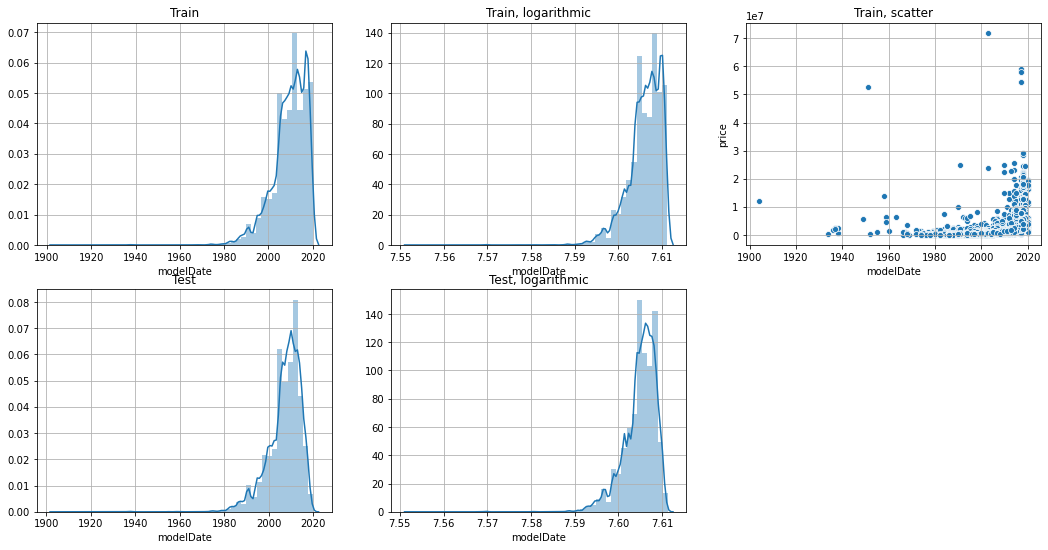

In [42]:
num_cols.append(col)
train[col] = train[col].astype(dtype=np.uint32)
test[col] = test[col].astype(dtype=np.uint32)
cm.plot_num_col_vs_price_unified(train, test, col)

Логарифмирование практически не меняет форму распределений, заметен тренд на более высокую цену для более поздних моделей автомобилей.

### Владельцы

In [43]:
col = 'Владельцы'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

3 или более    13121
1 владелец      8738
2 владельца     7731
Name: Владельцы, dtype: int64

Num of missing values: 6620


3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

Num of missing values: 0


Преобразуем признак к численному виду (0,1,2,3 соответственно), заполняя пропуски в train нулевыми значениями.

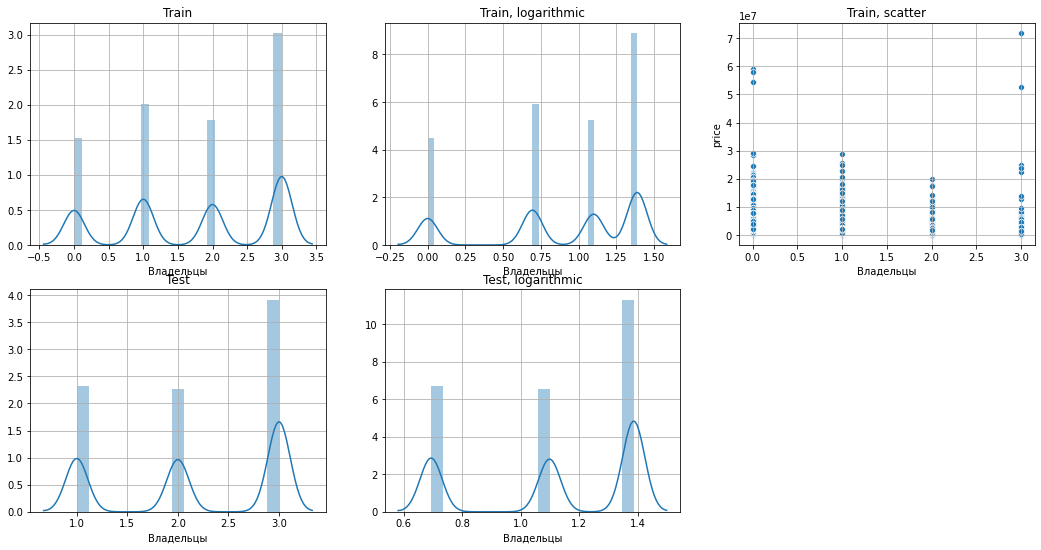

In [44]:
num_cols.append(col)
train[col] = train[col].fillna('0 или более')
train[col] = train[col].apply(cm.clear_owners).astype(np.uint8)
test[col] = test[col].fillna('0 или более')
test[col] = test[col].apply(cm.clear_owners).astype(np.uint8)
cm.plot_num_col_vs_price_unified(train, test, col)

Признак принимает дискретные значения, на диаграмме рассеяния нет заметной связи с ценой автомобиля.

### numberOfDoors

In [45]:
col = 'numberOfDoors'
cm.print_col_info(train[col])
cm.print_col_info(test[col])

5.0    22449
4.0    12263
2.0      961
3.0      536
Name: numberOfDoors, dtype: int64

Num of missing values: 0


5    18703
4    14126
2     1206
3      650
Name: numberOfDoors, dtype: int64

Num of missing values: 0


Численный признак без пропусков, принимающий дискретные значения. 

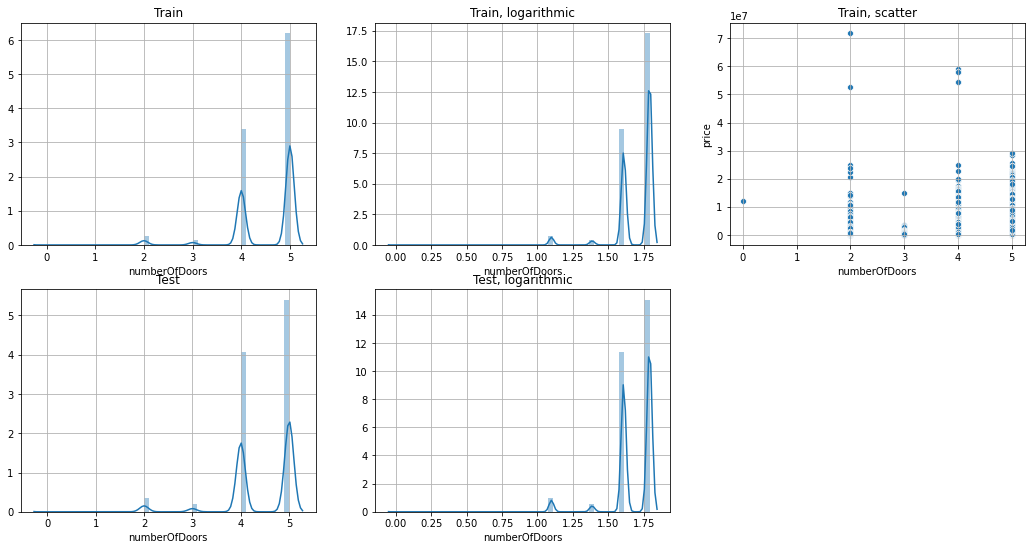

In [46]:
num_cols.append(col)
train[col] = train[col].astype(np.uint8)
test[col] = test[col].astype(np.uint8)
cm.plot_num_col_vs_price_unified(train, test, col)

НАибольшую долю соствляют автомобили с кол-вом дверей 4 или 5, заметной связи с ценой не обнаружено. Признак скорее всего не нуждается в логарифмировании.

### Feature engineering

In [47]:
col = 'equipment_dict'
new_col = col + '_clear'
train[col] = train[col].fillna('')
test[col] = test[col].fillna('')
train[new_col] = train[col].apply(cm.clear_equipment_dict)
test[new_col] = test[col].apply(cm.clear_equipment_dict)

print(list(sorted(cm.equipment_all_categories))[::30])
print(len(cm.equipment_all_categories))

['03B', '274', '4UC', '824', 'P29', 'advanced_frontlighting_system', 'blind_spot', 'electro_rear_seat', 'keyless_entry', 'power_latching_doors', 'steel_wheels']
325


На основе признака equipment_dict создадим некоторое кол-во категориальных признаков, обозначающих наличие у автомобиля той или иной доп опции, которая потенциально увеличивает цену (например, сиденья из кожи, мешки безопаности и пр). Всего насчитывается 325 возможных опций, но добавим только часть (а именно 27), т.к. не все опции улучшают качество предсказания финальной модели.

In [48]:
# add_features = ['xenon', 'other', '12v_socket', 'activ_suspension', 'adaptive_light', 'advanced_frontlighting_system', 'airbag_driver', 'airbag_passenger',
#                'alarm', 'android_auto', 'apple_carplay']
# add_features = sorted(cm.equipment_all_categories)
add_features = ['airbag_side', 'airbrush', 'alarm', 'alcantara', 'alloy_wheel_disks', 'android_auto', 'apple_carplay', 'armored', 'ashtray_and_cigarette_lighter', 'asr', 'audiopreparation', 'audiosystem_cd', 'audiosystem_tv', 'auto_cruise', 'auto_mirrors', 'auto_park', 'automatic_lighting_control', 'aux', 'bas', 'black_roof', 'blind_spot', 'bluetooth', 'body_kit', 'body_mouldings', 'climate_control', 'climate_control_1', 'climate_control_2']
print(len(add_features))

for add_feature in add_features:
    add_feature_col = 'equipment_' + add_feature
    train[add_feature_col] = train[new_col].apply(lambda d: d.get(add_feature,0)).astype(np.uint8)
    test[add_feature_col] = test[new_col].apply(lambda d: d.get(add_feature,0)).astype(np.uint8)
    add_cols.append(add_feature_col)

27


Также добавим численный признак, обозначающий средний пробег автомобиля в год с момента выпуска. Данный признак является важным и снижает MAPE финальной модели, входя в топ-10 признаков по значимости.

In [49]:
col1 = 'mileage'
col2 = 'productionDate'
new_col = 'mileage_per_year'

train[new_col] = np.round(train[col1] / (2020 - train[col2] + 1)).astype(np.uint32)
test[new_col] = np.round(test[col1] / (2020 - test[col2] + 1)).astype(np.uint32)

num_cols.append(new_col)

### All features

Существуют признаки (такие, как ПТС или Руль), которые ухудшают качество финальной модели, добавлять их не будем.

In [50]:
columns = cat_cols + num_cols + add_cols + ['car_url', 'sell_id']
print(len(columns))
print(train[columns].isna().sum().sum(), test[columns].isna().sum().sum())
# train.dropna(subset=columns, inplace=True)

45
0 0


Итого 45 признаков (некоторые из которых еще нужно закодировать с помощью One-Hot Encoding), без каких-либо пропусков.

In [51]:
df_train = train[columns]
y = train['price']
df_test = test[columns]

### Price

650000    350
450000    326
550000    308
750000    268
Name: price, dtype: int64

Num of missing values: 0


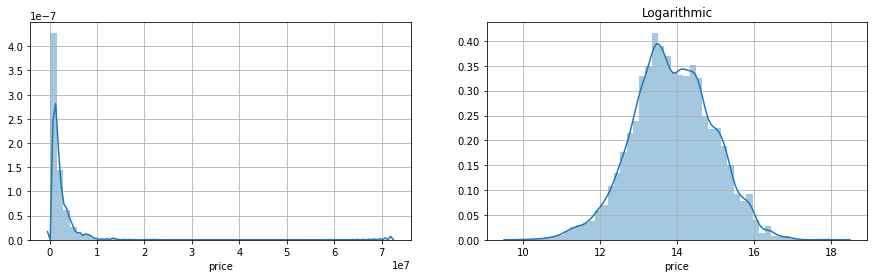

In [52]:
col = 'price'
cm.print_col_info(train[col])
cm.plot_num_col(train, col)

Целевая переменная в train не содержит пропусков. Заметно, что распределение приобретает нормальную форму после логарифмирования. Без логарифмирования наблюдается длинный хвост в области высоких цен (более 10 млн).

## One-Hot Encoding

Для корректной обработки признаков объединяем трейн и тест в один датасет.

In [53]:
pd.options.mode.chained_assignment = None  # default='warn'

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [54]:
cm.print_duplicates_info(data)
data.drop(columns=['car_url', 'sell_id'], inplace=True)

Num of duplicates by car_url: 10472
Num of duplicates by sell_id: 0
Num of duplicates by car_url, sell_id: 0


Проанализируем наличие дубликатов в объединенном датасете. Всего таких строк 10472, что означает, что train и test примерно на треть состоят из одинаковых данных. 

In [55]:
data_prepared = pd.get_dummies(data.copy(), columns=cat_cols)
data_prepared.head(5)

,productionDate,engineDisplacement,mileage,enginePower,modelDate,Владельцы,numberOfDoors,mileage_per_year,equipment_airbag_side,equipment_airbrush,equipment_alarm,equipment_alcantara,equipment_alloy_wheel_disks,equipment_android_auto,equipment_apple_carplay,equipment_armored,equipment_ashtray_and_cigarette_lighter,equipment_asr,equipment_audiopreparation,equipment_audiosystem_cd,equipment_audiosystem_tv,equipment_auto_cruise,equipment_auto_mirrors,equipment_auto_park,equipment_automatic_lighting_control,equipment_aux,equipment_bas,equipment_black_roof,equipment_blind_spot,equipment_bluetooth,equipment_body_kit,equipment_body_mouldings,equipment_climate_control,equipment_climate_control_1,equipment_climate_control_2,sample,bodyType_внедорожник,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_микровэн,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_пикап одинарная кабина,bodyType_пикап полуторная кабина,bodyType_родстер,bodyType_седан,bodyType_седан-хардтоп,bodyType_тарга,bodyType_универсал,bodyType_фастбек,bodyType_фургон,bodyType_хэтчбек,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO,Привод_задний,Привод_передний,Привод_полный,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,color_OTHER,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_красный,color_оранжевый,color_розовый,color_серый,color_синий,color_фиолетовый,color_чёрный,model_name_100,model_name_100NX,model_name_100_SERIES,model_name_140_SERIES,model_name_200,model_name_240_SERIES,model_name_280ZX,model_name_300ZX,model_name_321,model_name_326,model_name_340,model_name_350Z,model_name_440,model_name_460,model_name_4RUNNER,model_name_740,model_name_760,model_name_80,model_name_850,model_name_90,model_name_920,model_name_940,model_name_960,model_name_A1,model_name_A2,model_name_A3,model_name_A4,model_name_A4_ALLROAD,model_name_A5,model_name_A6,model_name_A7,model_name_A8,model_name_ACCORD,model_name_ACTY,model_name_AD,...,model_name_S8,model_name_S80,model_name_S90,model_name_SABER,model_name_SAFARI,model_name_SC,model_name_SCIROCCO,model_name_SENTRA,model_name_SEQUOIA,model_name_SERA,model_name_SERENA,model_name_SHARAN,model_name_SHUTTLE,model_name_SIENNA,model_name_SIENTA,model_name_SILVIA,model_name_SIMPLEX,model_name_SKYLINE,model_name_SLK_CLASS,model_name_SLS_AMG,model_name_SL_CLASS,model_name_SL_CLASS_AMG,model_name_SOARER,model_name_SPACE_GEAR,model_name_SPACE_STAR,model_name_SPACE_WAGON,model_name_SPADE,model_name_SPARKY,model_name_SPRINTER,model_name_SPRINTER_CARIB,model_name_SPRINTER_MARINO,model_name_SPRINTER_TRUENO,model_name_SQ5,model_name_STAGEA,model_name_STARLET,model_name_STEPWAGON,model_name_STREAM,model_name_SUCCEED,model_name_SUNNY,model_name_SUPERB,model_name_SUPRA,model_name_S_CLASS,model_name_S_CLASS_AMG,model_name_TEANA,model_name_TERAMONT,model_name_TERCEL,model_name_TERRANO,model_name_TERRANO_REGULUS,model_name_TIGUAN,model_name_TIIDA,model_name_TINO,model_name_TORNEO,model_name_TOUAREG,model_name_TOURAN,model_name_TOWN_ACE,model_name_TRANSPORTER,model_name_TT,model_name_TTS,model_name_TUNDRA,model_name_TYPE_1,model_name_UX,model_name_V40,model_name_V40_CROSS_COUNTRY,model_name_V50,model_name_V60,model_name_V60_CROSS_COUNTRY,model_name_V70,model_name_V8,model_name_V90_CROSS_COUNTRY,model_name_VANETTE,model_name_VANGUARD,model_name_VELLFIRE,model_name_VENTO,model_name_VENZA,model_name_VEROSSA,model_name_VERSO,model_name_VERSO_S,model_name_VEZEL,model_name_VIANO,model_name_VIGOR,model_name_VISTA,model_name_VITO,model_name_VITZ,model_name_VOXY,model_name_V_CLASS,model_name_W111,model_name_W114,model_name_W123,model_name_W124,model_name_W128,model_name_W188,model_name_WINDOM,model_name_WINGROAD,model_name_WISH,model_name_X1,model_name_X2,model_name_X3,model_name_X3_M,model_name_X4,m

Для кодирования категориальных переменных используется One-Hot Encoding.

## EDA

Прологарифмируем признаки, для которых это целесообразно, а также целевую переменную - для распределения, приближенного к нормальному и уменьшению выбросов.

In [56]:
display(data_prepared[num_cols].describe())

y = np.log(y)

num_cols_not_log = ['Владельцы', 'numberOfDoors']
for col in num_cols:
    if not col in num_cols_not_log:
        data_prepared[col] = np.log(data_prepared[col] + 1)
        
        
display(data_prepared[num_cols].describe())

,productionDate,engineDisplacement,mileage,enginePower,modelDate,Владельцы,numberOfDoors,mileage_per_year
count,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000
mean,2010.500931,2.368425,143590.193847,189.880890,2008.329342,1.966726,4.502483,13278.843983
std,7.293398,0.934679,105029.955056,88.469009,7.616480,1.019428,0.683679,8024.319025
min,1904.000000,0.000000,0.000000,30.000000,1904.000000,0.000000,0.000000,0.000000
25%,2007.000000,1.800000,67000.000000,133.000000,2005.000000,1.000000,4.000000,9011.250000
50%,2012.000000,2.000000,134000.000000,170.000000,2010.000000,2.000000,5.000000,13043.000000
75%,2016.000000,3.000000,200000.000000,235.000000,2014.000000,3.000000,5.000000,17286.750000
max,2020.000000,6.600000,1000000.000000,700.000000,2020.000000,3.000000,5.000000,110578.000000


,productionDate,engineDisplacement,mileage,enginePower,modelDate,Владельцы,numberOfDoors,mileage_per_year
count,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000,70896.000000
mean,7.606630,1.181312,10.595906,5.161418,7.605549,1.966726,4.502483,8.561619
std,0.003634,0.250493,3.537151,0.416285,0.003801,1.019428,0.683679,2.831308
min,7.552237,0.000000,0.000000,3.433987,7.552237,0.000000,0.000000,0.000000
25%,7.604894,1.029619,11.112463,4.897840,7.603898,1.000000,4.000000,9.106340
50%,7.607381,1.098612,11.805603,5.141664,7.606387,2.000000,5.000000,9.476084
75%,7.609367,1.386294,12.206078,5.463832,7.608374,3.000000,5.000000,9.757753
max,7.611348,2.028148,13.815512,6.552508,7.611348,3.000000,5.000000,11.613485


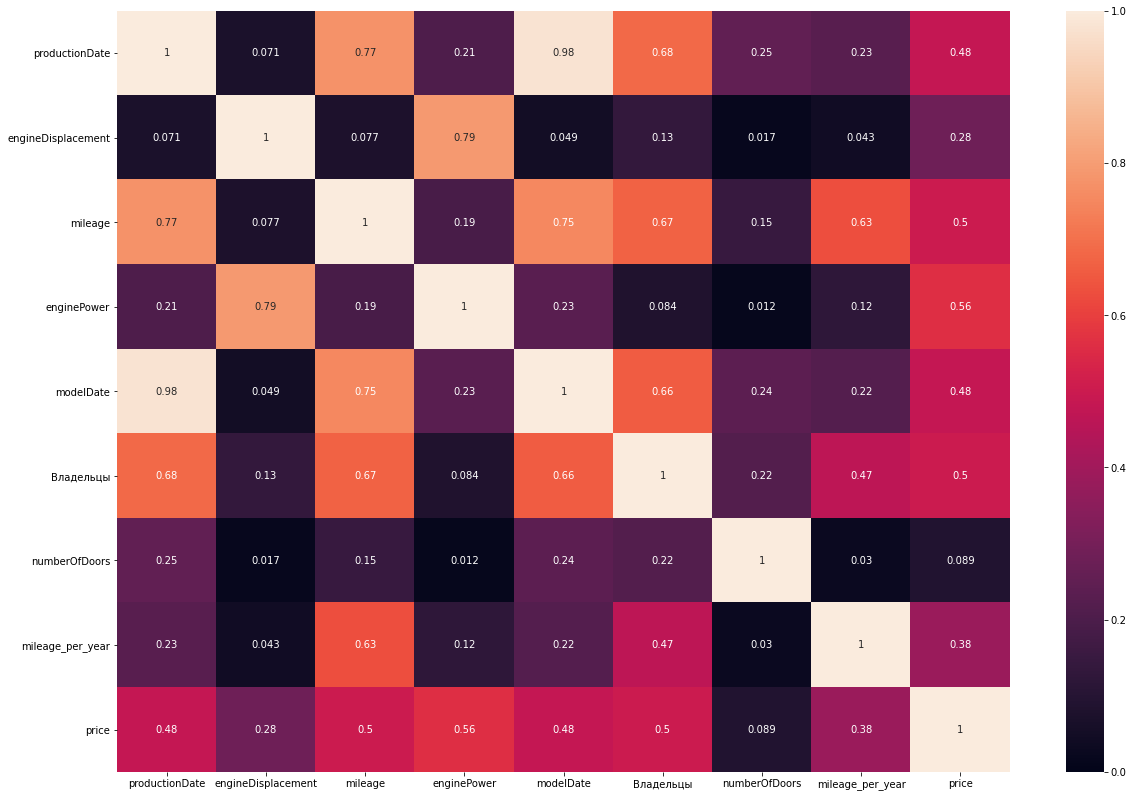

In [57]:
columns_for_corr = num_cols.copy() + ['price']
cm.plot_corr_matrix(train, columns_for_corr)

Заметно, что среди численных признаков есть некоторые пары с высокой корреляцией. Однако удалять их пока не будем, т.к. не планируется использование линейных моделей (линейной регресиии), а для других моделей может быть выгоднее оставить все признаки. 

In [58]:
X = data_prepared.query('sample == 1').drop(['sample'], axis=1)
X_sub = data_prepared.query('sample == 0').drop(['sample'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [59]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [60]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
y_pred = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность 
cm.print_mape(cm.mape(np.exp(y_test), np.exp(y_pred.values)))

Точность модели по метрике MAPE: 109.80%


"Наивная" модель на валидации демонстрирует низкую точность, поэтому нет смысла делать submission. Далее рассмотрим ML модели

# Model 2: CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


Для работы с категориальными данными была создана очень удобная библиотека CatBoost от Яндекса.

Вначале попробуем найти оптимальные гиперпараметры данной модели

In [61]:
model = cm.get_catboost_model_default()
pprint(model.get_params())

param_grid = {'depth': [4, 8, None],
              'learning_rate': [LR / 5, LR, LR * 5]}

grid_search_result = model.grid_search(param_grid,
                                       X=X,
                                       y=y,
                                       cv=3,
                                       partition_random_seed=RANDOM_SEED,
                                       verbose=False,
                                       plot=False)

best_params = grid_search_result['params']
display(best_params)

{'custom_metric': ['R2', 'MAE'],
 'eval_metric': 'MAPE',
 'iterations': 5000,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}


{'depth': 4, 'learning_rate': 0.1}

In [62]:
model = cm.get_catboost_model_default()
model_params = model.get_params()
model_params['depth'] = best_params['depth']
model_params['learning_rate'] = best_params['learning_rate']
model = model.set_params(**model_params)
pprint(model.get_params())


model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=1000,
          use_best_model=True,
          plot=False)

y_pred = model.predict(X_test)
cm.print_mape(cm.mape(np.exp(y_test), np.exp(y_pred)))

{'custom_metric': ['R2', 'MAE'],
 'depth': 4,
 'eval_metric': 'MAPE',
 'iterations': 5000,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}
Точность модели по метрике MAPE: 11.64%


Точность модели на валидации составила 11.64%

In [63]:
predict_submission = model.predict(X_sub)

predict_submission = np.exp(predict_submission)
predict_submission = cm.get_round_price(predict_submission)
sample_submission = cm.make_submission(sample_submission, predict_submission, False)

,sell_id,price
0,1100575026,632500.0
1,1100549428,1025200.0
2,1100658222,955300.0
3,1100937408,761400.0
4,1101037972,735400.0
5,1100912634,742300.0
6,1101228730,683500.0
7,1100165896,427800.0
8,1100768262,2060900.0
9,1101218501,813600.0


Точность модели на тестовых данных составила 12.63, что достаточно неплохо. Попробуем обучить другие модели на тех же данных

# Model 3: RandomForestRegressor

Подберем оптимальные гиперпараметры для модели RandomForestRegressor

In [64]:
model = cm.get_rf_model_default()
pprint(model.get_params())

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [4, 10, None]}

model_tune = GridSearchCV(estimator=model, param_grid=param_grid, scoring=cm.get_scorer(), cv=3, n_jobs=-1)
model_tune.fit(X, y)
display(model_tune.best_estimator_, model_tune.best_params_)
best_params = model_tune.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(n_jobs=-1, random_state=42)

{'max_depth': None, 'max_features': 'auto'}

Оптимальными являются параметры по умолчанию

In [65]:
model = cm.get_rf_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)
pprint(model.get_params())


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm.print_mape(cm.mape(np.exp(y_test), np.exp(y_pred)))

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Точность модели по метрике MAPE: 12.17%


In [66]:
model = cm.get_rf_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)
pprint(model.get_params())

predict_submission = cm.predict_by_all_data(model, X, y, X_sub)

predict_submission = np.exp(predict_submission)
predict_submission = cm.get_round_price(predict_submission)
sample_submission = cm.make_submission(sample_submission, predict_submission, False)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


,sell_id,price
0,1100575026,599200.0
1,1100549428,1127000.0
2,1100658222,841700.0
3,1100937408,824300.0
4,1101037972,649000.0
5,1100912634,778500.0
6,1101228730,633100.0
7,1100165896,341600.0
8,1100768262,1990800.0
9,1101218501,747700.0


Точность модели на тестовых данных составила 11.39, что еще лучше, чем CatBoost. Проверим еще одну модель, а также блендинг/стекинг нескольких моделей

# Model 4: ExtraTreesRegressor

In [67]:
model = cm.get_extr_model_default()
pprint(model.get_params())

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [4, 10, None]}

model_tune = GridSearchCV(estimator=model, param_grid=param_grid, scoring=cm.get_scorer(), cv=3, n_jobs=-1)
model_tune.fit(X, y)
display(model_tune.best_estimator_, model_tune.best_params_)
best_params = model_tune.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


ExtraTreesRegressor(n_jobs=-1, random_state=42)

{'max_depth': None, 'max_features': 'auto'}

In [68]:
model = cm.get_extr_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)
pprint(model.get_params())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm.print_mape(cm.mape(np.exp(y_test), np.exp(y_pred)))

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Точность модели по метрике MAPE: 12.03%


Для ExtraTreesRegressor оптимальными параметрами являются параметры по умолчанию, на валидации несколько лучший результат. Используем эту модель в дальнейшем, в том числе для блендинга/стекинга

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


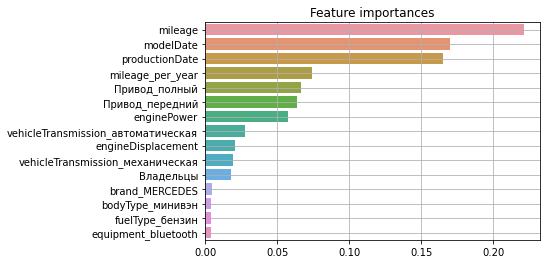

,sell_id,price
0,1100575026,603800.0
1,1100549428,1085300.0
2,1100658222,841900.0
3,1100937408,813300.0
4,1101037972,696700.0
5,1100912634,701200.0
6,1101228730,660800.0
7,1100165896,314000.0
8,1100768262,1962400.0
9,1101218501,763500.0


In [69]:
model = cm.get_extr_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)
pprint(model.get_params())

predict_submission = cm.predict_by_all_data(model, X, y, X_sub)
cm.plot_feature_importances(model, X)

predict_submission = np.exp(predict_submission)
predict_submission = cm.get_round_price(predict_submission)
sample_submission = cm.make_submission(sample_submission, predict_submission, False)

На тестовых данных модель ExtraTreesRegressor показывает точность около 9.8 %, что достаточно хорошо

# Model 5: Stacking

In [70]:
model = cm.get_extr_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)

model_list = cm.get_models_diff_random_state(model)
random_list = [model.get_params()['random_state'] for model in model_list]
display(random_list)

models_with_idx = zip(model_list, range(0,len(model_list)))
estimators = [('model_'+str(n), model) for model, n in models_with_idx]
display(estimators)

[42, 84, 126, 168, 210]

[('model_0', ExtraTreesRegressor(n_jobs=-1, random_state=42)),
 ('model_1', ExtraTreesRegressor(n_jobs=-1, random_state=84)),
 ('model_2', ExtraTreesRegressor(n_jobs=-1, random_state=126)),
 ('model_3', ExtraTreesRegressor(n_jobs=-1, random_state=168)),
 ('model_4', ExtraTreesRegressor(n_jobs=-1, random_state=210))]

In [71]:
stacking_model = StackingRegressor(estimators=estimators,
                                   # passthrough=True,
                                   cv=3,
                                   n_jobs=-1)
stacking_model.fit(X, y)
predict_submission = stacking_model.predict(X_sub)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [72]:
predict_submission = np.exp(predict_submission)
predict_submission = cm.get_round_price(predict_submission)
sample_submission = cm.make_submission(sample_submission, predict_submission, False)

,sell_id,price
0,1100575026,605000.0
1,1100549428,1112600.0
2,1100658222,840100.0
3,1100937408,811100.0
4,1101037972,697000.0
5,1100912634,717000.0
6,1101228730,657400.0
7,1100165896,316000.0
8,1100768262,1968000.0
9,1101218501,761000.0


Применение стекинга нескольких моделей ExtraTreesRegressor с разными random_state только ухудшило результат, поэтому нет смысла пробовать стекинг с более худшими моделями. Попробуем применить простой блендинг в виде усреднения

# Model 6: Blending

In [73]:
model = cm.get_extr_model_default()
model_params = model.get_params()
model_params['max_features'] = best_params['max_features']
model_params['max_depth'] = best_params['max_depth']
model = model.set_params(**model_params)

model_list = cm.get_models_diff_random_state(model,15)
random_list = [model.get_params()['random_state'] for model in model_list]
models_with_idx = zip(model_list, range(0,len(model_list)))
estimators = [('model_'+str(n), model) for model, n in models_with_idx]
display(estimators)

[('model_0', ExtraTreesRegressor(n_jobs=-1, random_state=42)),
 ('model_1', ExtraTreesRegressor(n_jobs=-1, random_state=84)),
 ('model_2', ExtraTreesRegressor(n_jobs=-1, random_state=126)),
 ('model_3', ExtraTreesRegressor(n_jobs=-1, random_state=168)),
 ('model_4', ExtraTreesRegressor(n_jobs=-1, random_state=210)),
 ('model_5', ExtraTreesRegressor(n_jobs=-1, random_state=252)),
 ('model_6', ExtraTreesRegressor(n_jobs=-1, random_state=294)),
 ('model_7', ExtraTreesRegressor(n_jobs=-1, random_state=336)),
 ('model_8', ExtraTreesRegressor(n_jobs=-1, random_state=378)),
 ('model_9', ExtraTreesRegressor(n_jobs=-1, random_state=420)),
 ('model_10', ExtraTreesRegressor(n_jobs=-1, random_state=462)),
 ('model_11', ExtraTreesRegressor(n_jobs=-1, random_state=504)),
 ('model_12', ExtraTreesRegressor(n_jobs=-1, random_state=546)),
 ('model_13', ExtraTreesRegressor(n_jobs=-1, random_state=588)),
 ('model_14', ExtraTreesRegressor(n_jobs=-1, random_state=630))]

In [74]:
predict_submission = np.zeros(X_sub.shape[0])

for name, model in estimators:
#     model_params = model.get_params()
#     pprint(model_params['n_estimators'])
#     model_params['n_estimators'] = 100
#     model = model.set_params(**model_params)
#     pprint(model.get_params()['n_estimators'])
    
    predict_submission += cm.predict_by_all_data(model, X, y, X_sub)
else:    
    predict_submission /= len(estimators)

In [75]:
predict_submission = np.exp(predict_submission)
predict_submission = cm.get_round_price(predict_submission)
sample_submission = cm.make_submission(sample_submission, predict_submission, True)

,sell_id,price
0,1100575026,601300.0
1,1100549428,1099700.0
2,1100658222,839800.0
3,1100937408,807200.0
4,1101037972,695200.0
5,1100912634,708800.0
6,1101228730,656000.0
7,1100165896,314000.0
8,1100768262,1960100.0
9,1101218501,756000.0


Применение блендинга улучшило score

# Сonclusions

При выполнении проекта была проведена предобработка набора данных по объявлениям c auto.ru, очищены существующие и сгенерированы новые признаки. Наилучший результат показала модель ExtraTreesRegressor, а также усреднение результатов данной модели для различных random_state